In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning')


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import data_loader
from models.ganin import GaninModel


In [ ]:
# Hyperparameters
IMG_SIZE = 28
BATCH_SIZE = 64
EPOCHS = 1
LR = 2e-4

In [ ]:
# MNIST
transform_m = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

trainset_m = datasets.MNIST("./data/mnist",
                            train=True,
                            download=False,
                            transform=transform_m)
trainloader_m = torch.utils.data.DataLoader(trainset_m,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True)

testset_m = datasets.MNIST("./data/mnist",
                           train=False,
                           download=False,
                           transform=transform_m)
testloader_m = torch.utils.data.DataLoader(testset_m,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

# MNIST-M
transform_mm = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

DATA_DIR = "data/mnist_m/processed/"

trainloader_mm = data_loader.fetch(
    data_dir=os.path.join(DATA_DIR, 'mnist_m_train.pt'),
    batch_size=BATCH_SIZE,
    shuffle=True,
    transform=transform_mm,
)

testloader_mm = data_loader.fetch(
    data_dir=os.path.join(DATA_DIR, 'mnist_m_test.pt'),
    batch_size=BATCH_SIZE,
    shuffle=False,
    transform=transform_mm,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = GaninModel().to(device)

criterion_l = nn.CrossEntropyLoss()
criterion_d = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

num_batches = min(len(trainloader_m), len(trainloader_mm)) # ~60000/batch_size


In [ ]:
num_batches

938

In [ ]:
test_accuracy = []


for epoch in range(EPOCHS):
    
    running_loss_total = 0
    running_loss_l = 0
    running_loss_d = 0

    dataiter_mm = iter(trainloader_mm)
    dataiter_m = iter(trainloader_m)
    lamda = (2 / (1 + np.exp(-10 * ((epoch + 0.0) / EPOCHS)))) - 1
    print(f"Lamda: {lamda}")

    net.train()
    for batch in range(1, num_batches+1):
        loss_total = 0
        loss_d = 0
        loss_l = 0

        optimizer.zero_grad()
        #for source domain
        imgs, lbls = dataiter_m.next()
        imgs, lbls = imgs.to(device), lbls.to(device)
        imgs = torch.cat((imgs, imgs, imgs), 1)
        out_l, out_d = net(imgs, lamda)  # lambda==lambda
        loss_l = criterion_l(out_l, lbls)
        actual_d = torch.zeros(out_d.shape)
        actual_d = actual_d.to(device)
        loss_d = criterion_d(out_d, actual_d)

        #for target domain
        imgs, lbls = dataiter_mm.next()
        imgs = imgs.to(device)
        _, out_d = net(imgs, lamda)
        actual_d = torch.ones(out_d.shape)
        actual_d = actual_d.to(device)
        loss_d += criterion_d(out_d, actual_d)

        loss_total = loss_d + loss_l
        loss_total.backward()
        optimizer.step()
        #scheduler.step()
        running_loss_total += loss_total
        running_loss_d += loss_d
        running_loss_l += loss_l

        if batch % 300 == 0:
          print(f"Epoch: {epoch}/{EPOCHS} Batch: {batch}/{num_batches}")
          print(f"Total Loss: {running_loss_total/batch}")
          print(f"Label Loss: {running_loss_l/batch}")
          print(f"Domain Loss: {running_loss_d/batch}")


    net.eval()
    test_loss = 0 
    accuracy = 0

    with torch.no_grad():
            net.eval()
            for imgs, lbls in testloader_mm:
                imgs, lbls = imgs.to(device), lbls.to(device)
                #print(logits.shape,lbls.shape)
                logits, _ = net(imgs, lamda)
                #print(logits.shape)
                #print(lbls.shape)
                #lbls = lbls.view(*logits.shape)
                #print(logits.shape,lbls.shape)
                test_loss += criterion_l(logits, lbls)

                #logits to probabilities using softmax
                ps = torch.exp(logits) / (torch.sum(torch.exp(logits)))
                top_p, top_class = ps.topk(1, dim=1)
                #print(top_p.shape, top_class.shape)
                equals = top_class == lbls.view(*top_class.shape)
                #print(top_class,lbls.view(*top_class.shape))
                accuracy += torch.mean(equals.float())

    test_accuracy.append(accuracy / len(testloader_mm))
    print(f"Test accuracy: {accuracy / len(testloader_mm)}")
    print("\n")


Lamda: 0.0


RuntimeError: ignored

In [ ]:
# np.save('test_accuracy.npy', test_accuracy)

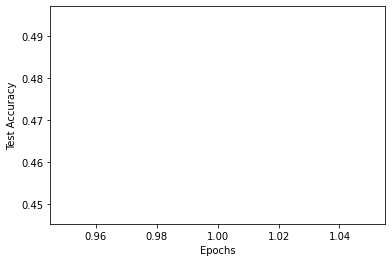

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(range(1,EPOCHS + 1),test_accuracy)
# plt.xlabel('Epochs')
# plt.ylabel('Test Accuracy')

# #plt.savefig('test_accuracy.pdf')
# plt.show()